In [1]:
%matplotlib inline
import random
import numpy as np

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.opflow import CircuitStateFn

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [2]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''    
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [3]:
def createActual(x, L):
    '''
    Takes a number and a size and returns a list of length l with all entries x.
    '''
    temp = []
    for i in range(L):
        temp = np.append(temp, x)
    return temp

In [4]:
'''
Define variables for the number of layers of the prover and the number of qubits.
'''
numQubit = 3
numLayer = 2

In [5]:
'''
Defines parameters that specify the purification of the three states.
'''
unitary_param_1 = np.array([])
for i in range(0, 8):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_2 = np.array([])
for i in range(0, 8):
    unitary_param_2 = np.append(unitary_param_2, np.array([rand_numb(0,2*np.pi)]))

unitary_param_3 = np.array([])
for i in range(0, 8):
    unitary_param_3 = np.append(unitary_param_3, np.array([rand_numb(0,2*np.pi)]))


'''
Defines the probabilities of the individual states
'''   
p1 = random.uniform(0, 1)
p2 = random.uniform(0, 1)
p3 = random.uniform(0, 1)
total = p1+p2+p3
[p_1, p_2, p_3] = [p1/total, p2/total, p3/total]

In [6]:
'''
Create purification of state 1
'''
size = 2
qc1 = QuantumCircuit(size)
for j in range(2):
    for i in range(size):
        qc1.rx(unitary_param_1[j*2*size + i], i)
        qc1.ry(unitary_param_1[j*2*size + i + size], i)  

    for i in range(size-1):
        qc1.cx(i, i+1)

qc1.draw()

┌────────────┐ ┌────────────┐     ┌─────────────┐ ┌────────────┐     
q_0: ─┤ Rx(1.4312) ├─┤ Ry(2.6291) ├──■──┤ Rx(0.57376) ├─┤ Ry(4.3515) ├──■──
     ┌┴────────────┤┌┴────────────┤┌─┴─┐├─────────────┤┌┴────────────┤┌─┴─┐
q_1: ┤ Rx(0.69369) ├┤ Ry(0.56228) ├┤ X ├┤ Rx(0.65572) ├┤ Ry(0.41006) ├┤ X ├
     └─────────────┘└─────────────┘└───┘└─────────────┘└─────────────┘└───┘

In [7]:
'''
Create purification of state 2
'''
size = 2
qc2 = QuantumCircuit(size)
for j in range(2):
    for i in range(size):
        qc2.rx(unitary_param_2[j*2*size + i], i)
        qc2.ry(unitary_param_2[j*2*size + i + size], i)

    for i in range(size-1):
        qc2.cx(i, i+1)

qc2.draw()

┌────────────┐ ┌────────────┐     ┌────────────┐┌────────────┐     
q_0: ┤ Rx(1.5368) ├─┤ Ry(5.9794) ├──■──┤ Rx(1.2932) ├┤ Ry(3.5394) ├──■──
     ├────────────┤┌┴────────────┤┌─┴─┐├────────────┤├────────────┤┌─┴─┐
q_1: ┤ Rx(3.2113) ├┤ Ry(0.22765) ├┤ X ├┤ Rx(3.7079) ├┤ Ry(5.1418) ├┤ X ├
     └────────────┘└─────────────┘└───┘└────────────┘└────────────┘└───┘

In [8]:
'''
Create purification of state 3
'''
size = 2
qc3 = QuantumCircuit(size)
for j in range(2):
    for i in range(size):
        qc3.rx(unitary_param_3[j*2*size + i], i)
        qc3.ry(unitary_param_3[j*2*size + i + size], i)

    for i in range(size-1):
        qc3.cx(i, i+1)

qc3.draw()

┌────────────┐┌────────────┐      ┌────────────┐┌────────────┐     
q_0: ┤ Rx(1.0561) ├┤ Ry(1.2141) ├──■───┤ Rx(5.8882) ├┤ Ry(3.5443) ├──■──
     ├────────────┤├────────────┤┌─┴─┐┌┴────────────┤├────────────┤┌─┴─┐
q_1: ┤ Rx(1.9645) ├┤ Ry(5.9332) ├┤ X ├┤ Rx(0.79039) ├┤ Ry(0.2369) ├┤ X ├
     └────────────┘└────────────┘└───┘└─────────────┘└────────────┘└───┘

In [9]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numParam = 2*numQubit*numLayer
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numParam)
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
    
    return prover

In [10]:
def createQuantumCircuits(numQubit, numLayer):
    '''
    Create three different quantum circuits corresponding to the three states followed by a measurement.
    Refer to Algorithm 19 from https://arxiv.org/pdf/2108.08406.pdf.
    '''
    qCirc1 = QuantumCircuit(4)
    qCirc2 = QuantumCircuit(4)
    qCirc3 = QuantumCircuit(4)
    
    #First unitary
    qCirc1.append(qc1, [0, 1])
    
    # Second unitary
    qCirc2.append(qc2, [0, 1])
    
    # Third unitary
    qCirc3.append(qc3, [0, 1])
    
    prover_qubits = [1, 2, 3]
    prover = createProver(numQubit, numLayer)
    qCirc1.append(prover, prover_qubits)
    qCirc2.append(prover, prover_qubits)
    qCirc3.append(prover, prover_qubits)
    
    return [qCirc1, qCirc2, qCirc3]

In [11]:
'''
Creates the quantum circuits.
'''
[qCirc1, qCirc2, qCirc3] = createQuantumCircuits(numQubit, numLayer)

In [38]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend)
sampler = CircuitSampler(q_instance)

In [22]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
sampler = CircuitSampler(quantum_instance)

In [39]:
'''
Average value of this hamiltonian is the probability of measuring 00 on the bottom two qubits.
Qiskit orders qubits in reverse.
'''
hamiltonian_00 = MatrixOp(np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))^I^I

'''
Average value of this hamiltonian is the probability of measuring 01 on the bottom two qubits.
Qiskit orders qubits in reverse.
'''
hamiltonian_01 = MatrixOp(np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]))^I^I

'''
Average value of this hamiltonian is the probability of measuring 10 on the bottom two qubits.
Qiskit orders qubits in reverse.
'''
hamiltonian_10 = MatrixOp(np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]))^I^I

'''
Average value of this hamiltonian is the probability of measuring 11 on the bottom two qubits.
Qiskit orders qubits in reverse.
'''
hamiltonian_11 = MatrixOp(np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1]]))^I^I

In [40]:
'''
Creates global variables that are used in the optimization. 
'''
global iters

In [41]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    Note: We return the negative of the expectation value because the optimizer only allows for minimization and we 
    want to maximize.
    '''
    value_dict = dict(zip(qCirc1.parameters, params))
    
    expectation00_1 = StateFn(hamiltonian_00, is_measurement=True).compose(StateFn(qCirc1))
    expectation01_2 = StateFn(hamiltonian_01, is_measurement=True).compose(StateFn(qCirc2))
    expectation10_3 = StateFn(hamiltonian_10, is_measurement=True).compose(StateFn(qCirc3))
    expectation11_1 = StateFn(hamiltonian_11, is_measurement=True).compose(StateFn(qCirc1))
    
    result00_1 = sampler.convert(expectation00_1, params=value_dict).eval()
    result01_2 = sampler.convert(expectation01_2, params=value_dict).eval()
    result10_3 = sampler.convert(expectation10_3, params=value_dict).eval()
    result11_1 = sampler.convert(expectation11_1, params=value_dict).eval()
    
    return -1*(p_1*np.real(result00_1) + p_2*np.real(result01_2) + p_3*np.real(result10_3) + p_1*np.real(result11_1))

In [29]:
'''
Initialize prover parameters to random angles.
'''
numParam = 2*numQubit*numLayer

param = []
for i in range(0, numParam):    
    param = np.append(param, np.array([rand_numb(0,2*np.pi)]))

print("Initial Cost : ", -1*costf(param)) 

Initial Cost :  0.2940973109810985


In [30]:
def spsa_callback(nfev, x, fx, stepsize, accepted):
    '''
    Callback function called automatically during optimization. Append loss value and print every 10 iterations with 
    a completion percentage.
    '''
    spsa_loss.append(-1*fx)
    if (nfev%1 == 0):
        print("Loss Value : ", -1*fx, str(100*nfev/(3*iters))+"%")

In [31]:
'''
Run optimization using the SPSA algorithm.
'''
spsa_loss = []
iters = 500
autospsa = SPSA(maxiter=iters, learning_rate=0.2, perturbation=0.05, callback=spsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=param)

Loss Value :  0.2936805177695759 0.2%
Loss Value :  0.3019872317077442 0.4%
Loss Value :  0.3293148246876024 0.6%
Loss Value :  0.3584562713716467 0.8%
Loss Value :  0.3660728719999799 1.0%
Loss Value :  0.367357552546437 1.2%
Loss Value :  0.379809908394546 1.4%
Loss Value :  0.3966270232280305 1.6%
Loss Value :  0.3971660631884544 1.8%
Loss Value :  0.41646764151406035 2.0%
Loss Value :  0.41817080296980763 2.2%
Loss Value :  0.44403115250083547 2.4%
Loss Value :  0.45196528903447863 2.6%
Loss Value :  0.45779550448241213 2.8%
Loss Value :  0.4738086520764231 3.0%
Loss Value :  0.46495381506242334 3.2%
Loss Value :  0.4949931614222949 3.4%
Loss Value :  0.5272148217432958 3.6%
Loss Value :  0.5208763734946493 3.8%
Loss Value :  0.5218866420257771 4.0%
Loss Value :  0.5380865305315641 4.2%
Loss Value :  0.5379243320808232 4.4%
Loss Value :  0.5442999212897583 4.6%
Loss Value :  0.538256821716893 4.8%
Loss Value :  0.5468937242756928 5.0%
Loss Value :  0.5622267375995867 5.2%
Loss Valu

Loss Value :  0.6509210978015567 42.8%
Loss Value :  0.649981823219091 43.0%
Loss Value :  0.6495091069248387 43.2%
Loss Value :  0.6492745915570298 43.4%
Loss Value :  0.6563267958148543 43.6%
Loss Value :  0.655916792034232 43.8%
Loss Value :  0.6559938296248582 44.0%
Loss Value :  0.6498902235349358 44.2%
Loss Value :  0.6543670822650025 44.4%
Loss Value :  0.6509703914759327 44.6%
Loss Value :  0.6435016240052318 44.8%
Loss Value :  0.6532490527381376 45.0%
Loss Value :  0.6470906210725563 45.2%
Loss Value :  0.6512144509616697 45.4%
Loss Value :  0.6472059766984797 45.6%
Loss Value :  0.6542265553453674 45.8%
Loss Value :  0.6493159220935586 46.0%
Loss Value :  0.6491283711017606 46.2%
Loss Value :  0.6533388503030723 46.4%
Loss Value :  0.6484161820921289 46.6%
Loss Value :  0.65127120456457 46.8%
Loss Value :  0.6544082300677329 47.0%
Loss Value :  0.6551733120013321 47.2%
Loss Value :  0.6543402949410202 47.4%
Loss Value :  0.6493058124958092 47.6%
Loss Value :  0.6504036685864

Loss Value :  0.6566410661237495 85.0%
Loss Value :  0.6544297264919261 85.2%
Loss Value :  0.6546333748963333 85.4%
Loss Value :  0.6501779575245176 85.6%
Loss Value :  0.6512481691256247 85.8%
Loss Value :  0.6532262684913485 86.0%
Loss Value :  0.6543793162936972 86.2%
Loss Value :  0.6545861766849207 86.4%
Loss Value :  0.6553250990739207 86.6%
Loss Value :  0.6504739081937221 86.8%
Loss Value :  0.6477886817193841 87.0%
Loss Value :  0.6470901744716718 87.2%
Loss Value :  0.6533520313487908 87.4%
Loss Value :  0.6550858860838774 87.6%
Loss Value :  0.6489387897498411 87.8%
Loss Value :  0.653138451864831 88.0%
Loss Value :  0.6464372044646921 88.2%
Loss Value :  0.6525833540506971 88.4%
Loss Value :  0.6493202766790444 88.6%
Loss Value :  0.6533451808204311 88.8%
Loss Value :  0.6548239222218328 89.0%
Loss Value :  0.6513919710741666 89.2%
Loss Value :  0.6558473944397362 89.4%
Loss Value :  0.6486829874367159 89.6%
Loss Value :  0.6467962166485522 89.8%
Loss Value :  0.6510437675

In [32]:
print("Optimal Value : ", -1*fx_opt)
print("Optimal Parameters : ", x_opt)

Optimal Value :  0.6510078727652182
Optimal Parameters :  [-0.37565709  3.05304386  3.18707434  5.90327066 -0.00860321  4.7409835
  2.0586452   1.69653286  4.28870469  1.64395784  3.3696366   1.58085649]


In [42]:
param_noisy = x_opt
print("Noisy final cost: ", -1*costf(param_noisy))

Noisy final cost:  0.670989290378549


In [20]:
loss_noiseless = []
loss_noiseless.extend(spsa_loss)

In [33]:
loss_noisy = []
loss_noisy.extend(spsa_loss)

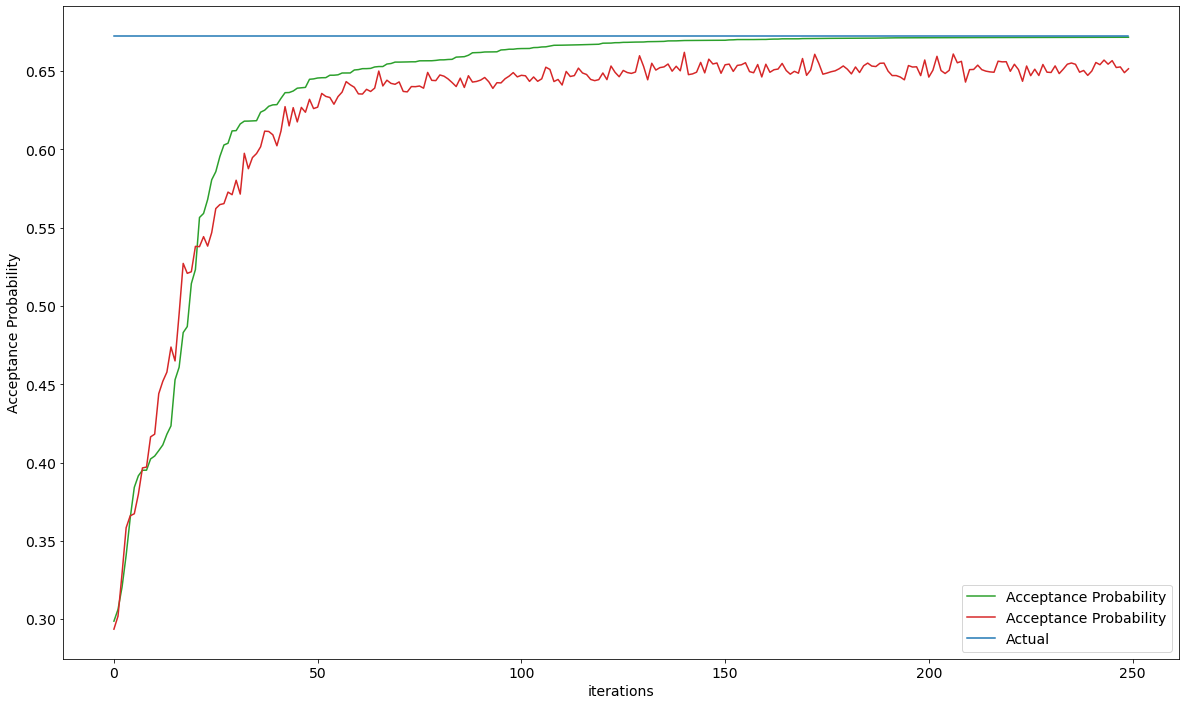

In [34]:
def plot_loss():
    '''
    Plots loss function. Actual root fidelity value can be calculated using SDP.
    '''
    start = 0
    end = 250
    plt.figure(figsize=(20, 12))
    plt.plot(loss_noiseless[start:end], 'tab:green', label='Acceptance Probability')
    plt.plot(loss_noisy[start:end], 'tab:red', label='Acceptance Probability')
    plt.plot(createActual(0.6723349065179771, len(loss_noiseless[start:end])), 'tab:blue', label='Actual')
    plt.ylabel('Acceptance Probability')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()
plot_loss()

<ipython-input-46-0de7e43a37ed>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("MultStateDiscr.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
<ipython-input-46-0de7e43a37ed>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("MultStateDiscr.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


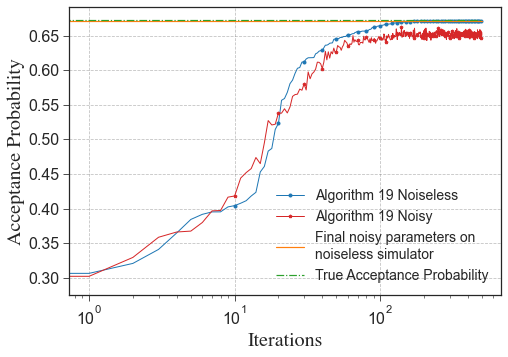

In [46]:
'''
To generate graph Figure 16 from https://arxiv.org/pdf/2108.08406.pdf
'''
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, LogLocator
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib import rc
from textwrap import wrap

#import rhinoscriptsytnax as rs

c1 = '#14A76C'
c6 = '#AC3B61'
c4 = '#2B7A78'
c2 = '#2E9CCA'
c5 = '#29648A'
c3 = '#F76C6C'

#m,c,k,g,r,b

#plt.rcParams['text.usetex'] = True
timesfont = {'fontname':'Times'}
style.use('seaborn-ticks')

start = 0
end = len(spsa_loss)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Plot and show our data
ax.plot(loss_noiseless[start:end],'-o', markersize=3.0, markevery=10, color = '#1f77b4', linewidth=1.0, label = 'Algorithm 19 Noiseless')
ax.plot(loss_noisy[start:end],'-p', markersize=3.0, markevery=10, color = "#d62728", linewidth=1.0, label = 'Algorithm 19 Noisy')
ax.plot(createActual(0.670989290378549, len(spsa_loss[start:end])), color = "#ff7f0e", linewidth=1.2 , label = '\n'.join(wrap('Final noisy parameters on noiseless simulator', 30)))
ax.plot(createActual(0.6723349065179771, len(spsa_loss[start:end])),'-.', color = "#2ca02c", linewidth=1.2 , label = 'True Acceptance Probability')
ax.set_xscale('log')
#ax.set_xlim(0, 1600)
ax.legend(loc=0)

ax.grid(b=True, which='major', color='#666666', linestyle='--',alpha=0.4)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Iterations',**timesfont,fontsize =20)
ax.set_ylabel('Acceptance Probability',**timesfont,fontsize =20)
#ax.set_xlabel('Iterations', labelpad=1)
#ax.set_ylabel('Fidelity', labelpad=10)
plt.savefig("MultStateDiscr.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
plt.show()